<a href="https://colab.research.google.com/github/doctorsmylie/mtg-draft-agent/blob/main/model-trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Configure Drive or Jupyter notebook -- only runs when first loaded
if "CONFIG_DONE" not in globals():
    # Need to mount drive and clone repo to access data and functions
    try:
        from google.colab import drive  # type: ignore

        IN_COLAB = True

        # clone repo
        !git clone https://github.com/doctorsmylie/mtg-draft-agent
        %cd mtg-draft-agent

    except ModuleNotFoundError:
        IN_COLAB = False

    # Finish configuration -- also configures notebook outside of Colab
    %run "project_path.ipynb"
else:
    print("Config done")

Cloning into 'mtg-draft-agent'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 238 (delta 5), reused 15 (delta 4), pack-reused 218 (from 1)
Receiving objects: 100% (238/238), 11.97 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/mtg-draft-agent
Starting config...
Running in Colab? Yes

Configuring Google Colab...
Mounting Drive...
Mounted at /content/mtg-draft-agent/drive
BASE_PATH =  /content/mtg-draft-agent
DATA_FOLDER = /content/mtg-draft-agent/drive/MyDrive/Erdos25/MTGdraft
BASE_PATH == os.getcwd(): True

Configuration done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

# from datasets import Dataset
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import pathlib
from itertools import product
from sklearn.model_selection import train_test_split

from time import time
from tqdm.auto import tqdm

import functions.card_io as card_io
import functions.utils as utils

# Setting device on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
drafts = pd.read_parquet('clean_data/DSK_drafts.parquet')

In [12]:
from bots.lstm_bot import *

# Model, Loss and Optimizer
vocab_size = 286

embed_dim = 128 #64
hidden_dim = 256 #128
num_layers = 5
p_LSTM = 0.3
p_out = 0.5
model = DraftBotLSTM(
    vocab_size, embed_dim, hidden_dim, num_layers=num_layers, p_LSTM=p_LSTM, p_out=p_out
)

batch_size = 64
loss_fn = nn.CrossEntropyLoss()

lr = 1e-2
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

In [13]:
# Split players into train/val/test
draft_ids = drafts["draft_id"].unique()

train_ids, temp_ids = train_test_split(draft_ids, test_size=0.2, random_state=304)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=304)

# Split Dataframe
drafts_train = drafts[drafts["draft_id"].isin(train_ids)]
drafts_val = drafts[drafts["draft_id"].isin(val_ids)]
drafts_test = drafts[drafts["draft_id"].isin(test_ids)]

# Create custom Datasets for each split
dataset_train = PlayerDataset(drafts_train)
dataset_val = PlayerDataset(drafts_val)
dataset_test = PlayerDataset(drafts_test)

In [14]:
# Create custom DataLoaders
dlss = []
for dataset in [dataset_train, dataset_val, dataset_test]:
    dls = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_player_turns
    )
    dlss.append(dls)

dls_train, dls_val, dls_test = dlss

In [15]:
# Training loop parameters
num_epochs = 25
num_turns = dataset_train.num_turns()

train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)

train_accuracies = torch.zeros((num_epochs, num_turns))
val_accuracies = torch.zeros((num_epochs, num_turns))

# Back propagate over the whole game
# If we omit this line, we back propagate over a single round of the draft
# (i.e. over 14 turns)
chunk_size = None

for epoch in range(num_epochs):
    # Train
    train_loss, train_accuracy_epoch = train_epoch(
        model, dls_train, optimizer, loss_fn, chunk_size=None, device=device
    )

    # Evaluate on validation set
    val_loss, val_accuracy_epoch = evaluate(model, dls_val, loss_fn, device=device)

    # Print results
    print(
        f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}\n"
    )

    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss

    train_accuracies[epoch, :] = train_accuracy_epoch.cpu()
    val_accuracies[epoch, :] = val_accuracy_epoch.cpu()

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/25: Train Loss = 1.0263, Val Loss = 1.0278



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2/25: Train Loss = 0.9690, Val Loss = 1.0236



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/25: Train Loss = 0.9646, Val Loss = 1.0202



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/25: Train Loss = 0.9620, Val Loss = 1.0189



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5/25: Train Loss = 0.9605, Val Loss = 1.0164



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/25: Train Loss = 0.9576, Val Loss = 1.0137



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/25: Train Loss = 0.9558, Val Loss = 1.0123



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 8/25: Train Loss = 0.9547, Val Loss = 1.0114



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/25: Train Loss = 0.9527, Val Loss = 1.0097



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/25: Train Loss = 0.9510, Val Loss = 1.0092



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/25: Train Loss = 0.9522, Val Loss = 1.0105



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 12/25: Train Loss = 0.9501, Val Loss = 1.0084



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/25: Train Loss = 0.9480, Val Loss = 1.0081



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/25: Train Loss = 0.9479, Val Loss = 1.0112



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/25: Train Loss = 0.9493, Val Loss = 1.0086



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/25: Train Loss = 0.9475, Val Loss = 1.0086



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/25: Train Loss = 0.9472, Val Loss = 1.0092



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18/25: Train Loss = 0.9455, Val Loss = 1.0090



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/25: Train Loss = 0.9441, Val Loss = 1.0087



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/25: Train Loss = 0.9447, Val Loss = 1.0084



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/25: Train Loss = 0.9442, Val Loss = 1.0090



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22/25: Train Loss = 0.9448, Val Loss = 1.0091



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/25: Train Loss = 0.9431, Val Loss = 1.0109



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/25: Train Loss = 0.9437, Val Loss = 1.0094



  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 25/25: Train Loss = 0.9429, Val Loss = 1.0111



In [9]:
# Calculate probability of random choice
tt = np.arange(14, dtype=float)
prob_random = 1 / np.flip(tt + 1)

(0.0, 1.04)

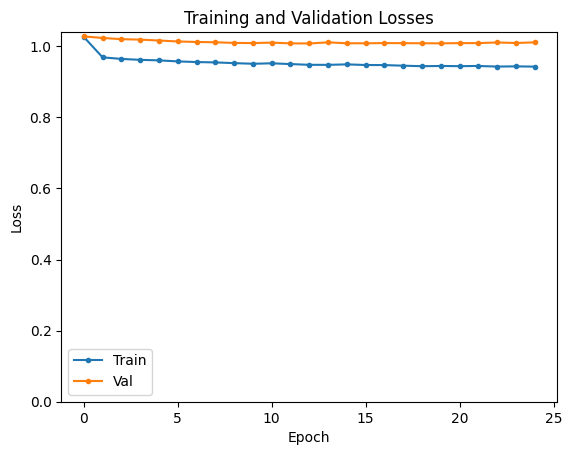

In [16]:
plt.plot(train_losses, label="Train", marker=".")
plt.plot(val_losses, label="Val", marker=".")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")

y_max = plt.ylim()[1]
y_max = utils.ceil_digit(y_max, digits=2)
plt.ylim(0, y_max)

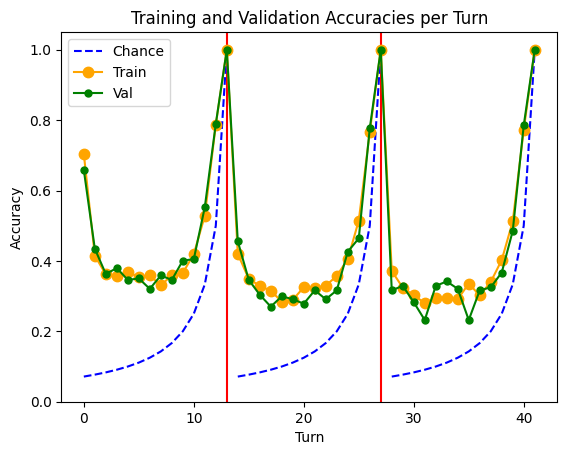

In [17]:
# Separate packs
plt.axvline(max_pack_size - 1, color="red")
plt.axvline(2 * max_pack_size - 1, color="red")

# Plot probability of random choice
plt.plot(tt, prob_random, "--", color="blue", label="Chance")
plt.plot(14 * 1 + tt, prob_random, "--", color="blue")
plt.plot(14 * 2 + tt, prob_random, "--", color="blue")

epoch = -1
plt.plot(
    train_accuracies[epoch, :], label="Train", marker=".", markersize=15, color="orange"
)
plt.plot(
    val_accuracies[epoch, :], label="Val", marker=".", markersize=10, color="green"
)
plt.legend()

plt.xlabel("Turn")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies per Turn")

plt.ylim([0, 1.05])

plt.show()

In [20]:
torch.save(model.state_dict(), "trained_models/lstm_params.pth")